In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
!pip install tensorflow-addons
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.4 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
model_path = r'/content/gdrive/MyDrive/Hasil_Train/Training/0DEG-EfficientNetB0-Train0.9-CV-TL_8Fold'
name = '0DEG-EfficientNetB0-Train0.9-CV-TL_8Fold'

if not os.path.exists(f'plots/{name}'):
  os.makedirs(f'plots/{name}')

#model = tf.keras.models.load_model(model_path) #loads saved model 
from keras.models import load_model
model = load_model('/content/gdrive/MyDrive/Hasil_Train/Training/0DEG-EfficientNetB0-Train0.9-CV-TL_8Fold/EfficientNet_8.h5')

In [24]:
arch = '0DEG-EfficientNetB0-Train0.9-CV-TL_8Fold'
name = 'EfficientNet_1'
degree = '0'

model_path = f"/content/gdrive/MyDrive/Hasil_Train/Training/0DEG-EfficientNetB0-Train0.9-CV-TL_8Fold/EfficientNet_1"

In [25]:
def get_model():
    #Create model
    base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet", 
                                                  input_shape=(224, 224, 3), pooling='avg')
    out = base_model.output
    prediction = tf.keras.layers.Dense(1, activation="linear")(out)
    model = tf.keras.Model(inputs = base_model.input, outputs = prediction)
      
    return model

In [26]:
model = get_model()
model.load_weights(f"{model_path}.h5")
opt = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-6)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae','mse', tfa.metrics.RSquare(name="R2")])

16719872/16705208 [==============================] - 1s 0us/step


0deg

In [34]:
from pathlib import Path
import os.path
image_dir = Path('/content/gdrive/MyDrive/Hasil_Train/Dataset_128/0deg_LED_resized')

90deg

In [ ]:
from pathlib import Path
import os.path
image_dir = Path('/content/gdrive/MyDrive/Hasil_Train/open_noLED_png_resized')

In [35]:
filepath = pd.Series(list(image_dir.glob(r'**/*.png')), name='Filepath').astype(str)
turbidity = pd.Series(filepath.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Turbidity').astype(np.float)

images = pd.concat([filepath, turbidity], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [36]:
train_df, test_df = train_test_split(images, train_size=0.9, shuffle=True, random_state=1) #Split into train and test set

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True
)

In [37]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Turbidity',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    shuffle=False,
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Turbidity',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    shuffle=False
)

Found 486 validated image filenames.
Found 55 validated image filenames.


In [38]:
train_pred = np.squeeze(model.predict(train_images))
train_true = train_images.labels
train_residuals = train_true - train_pred

test_pred = np.squeeze(model.predict(test_images))
test_true = test_images.labels
test_residuals = test_true - test_pred

In [39]:
from sklearn.metrics import mean_absolute_error as MAE
MAE_train = MAE(train_true,train_pred)
MAE_test = MAE(test_true,test_pred)
print(MAE_train)
print(MAE_test)

1.849327098366655
2.463858110254461


In [40]:
from sklearn.metrics import r2_score as r2
r2_train = r2(train_true,train_pred)
r2_test = r2(test_true,test_pred)
print(r2_train)
print(r2_test)

0.9952555741988685
0.9919759833509287


In [41]:
from sklearn.metrics import mean_squared_error as MSE
MSE_train = MSE(train_true,train_pred)
MSE_test = MSE(test_true,test_pred)
print(MSE_train)
print(MSE_test)

6.271855850670644
10.453534113097112


In [42]:
name = 'LINGKUNGANTERKONTROL_1'

if not os.path.exists(f'plots/{name}'):
  os.makedirs(f'plots/{name}')

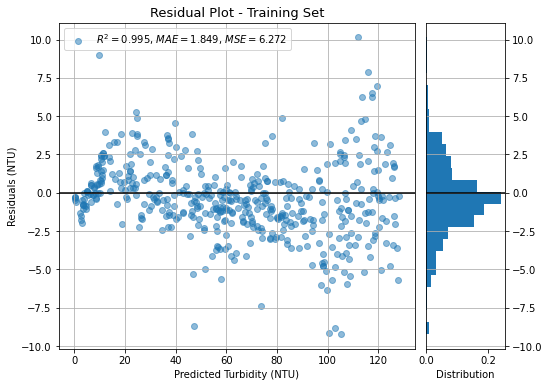

In [48]:
f, axs = plt.subplots(1, 2, figsize=(8,6), gridspec_kw={'width_ratios': [9, 2]})

axs[0].scatter(train_pred,train_residuals, label=f'$R^2=${round(r2_train,3)}, $MAE=${round(MAE_train,3)}, $MSE=${round(MSE_train,3)}', alpha=0.5, color='tab:blue')
axs[0].set_title('Residual Plot - Training Set', fontsize=13)           
axs[0].set_ylabel('Residuals (NTU)', fontsize=10)
axs[0].set_xlabel('Predicted Turbidity (NTU)', fontsize=10)      
axs[0].axhline(0, color='black')
axs[0].legend()
axs[0].grid()

axs[1].hist(train_residuals, bins=25, orientation="horizontal", density=True)
axs[1].axhline(0, color='black')
axs[1].set_xlabel('Distribution', fontsize=10)  
axs[1].yaxis.tick_right()
axs[1].grid(axis='y')

plt.subplots_adjust(wspace=0.05)
plt.savefig(f'plots/{name}/ResidualPlotTrain_{name}.png', dpi=300)
plt.show()

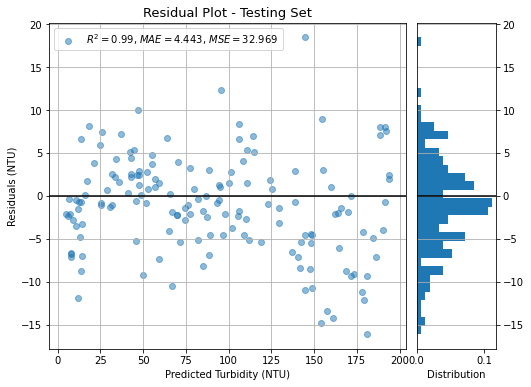

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(8,6), gridspec_kw={'width_ratios': [9, 2]})

axs[0].scatter(test_pred,test_residuals, label=f'$R^2=${round(r2_test,3)}, $MAE=${round(MAE_test,3)}, $MSE=${round(MSE_test,3)}', alpha=0.5, color='tab:blue')
axs[0].set_title('Residual Plot - Testing Set', fontsize=13)           
axs[0].set_ylabel('Residuals (NTU)', fontsize=10)
axs[0].set_xlabel('Predicted Turbidity (NTU)', fontsize=10)      
axs[0].axhline(0, color='black')
axs[0].legend()
axs[0].grid()

axs[1].hist(test_residuals, bins=35, orientation="horizontal", density=True)
axs[1].axhline(0, color='black')
axs[1].set_xlabel('Distribution', fontsize=10)  
axs[1].yaxis.tick_right()
axs[1].grid(axis='y')

plt.subplots_adjust(wspace=0.05)
plt.savefig(f'plots/{name}/ResidualPlotTest_{name}.png', dpi=300)
plt.show()

In [ ]:
history = pd.read_csv(f'{model_path}/history.csv')

loss = history['loss']
val_loss = history['val_loss']
ma_error = history['mae']
val_ma_error = history['val_mae']
r2 = history['R2']
val_r2 = history['val_R2']
ms_error = history['mse']
val_ms_error = history['val_mse']

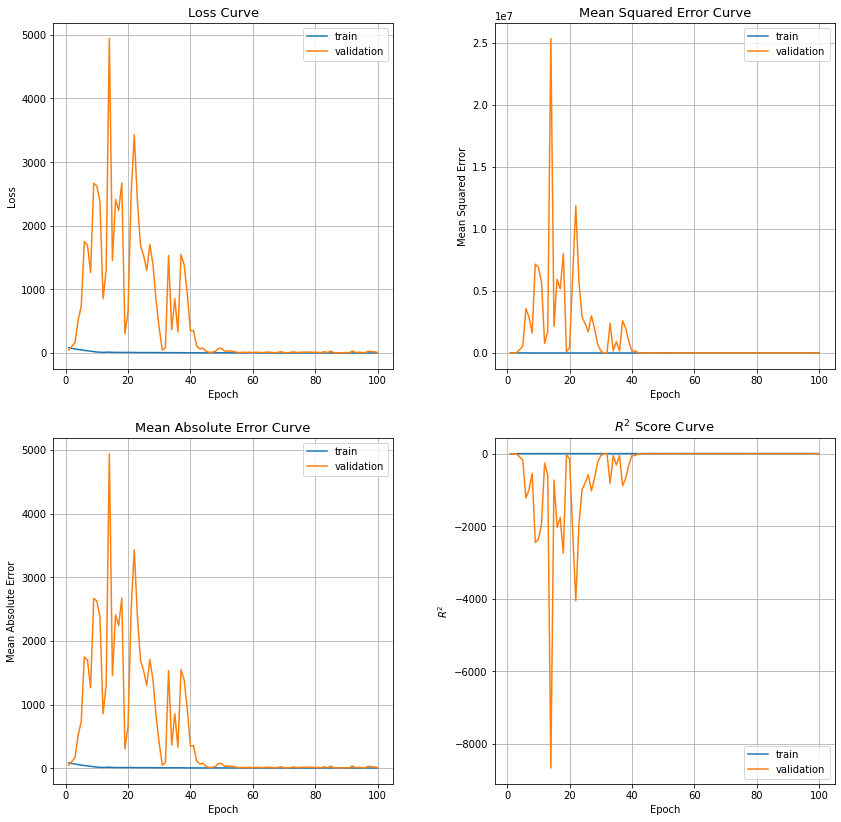

In [ ]:
epochs = range(1, len(loss) + 1)

f, axs = plt.subplots(2, 2, figsize=(14,14))

axs[0][0].plot(epochs, loss, 'tab:blue', label='train')
axs[0][0].plot(epochs, val_loss, 'tab:orange', label='validation')
axs[0][0].set_title('Loss Curve', fontsize=13)
axs[0][0].set_xlabel('Epoch', fontsize=10)
axs[0][0].set_ylabel('Loss', fontsize=10)
axs[0][0].legend()
axs[0][0].grid()

axs[0][1].plot(epochs, ms_error, 'tab:blue', label='train')
axs[0][1].plot(epochs, val_ms_error, 'tab:orange', label='validation')
axs[0][1].set_title('Mean Squared Error Curve', fontsize=13)
axs[0][1].set_xlabel('Epoch')
axs[0][1].set_ylabel('Mean Squared Error')
axs[0][1].legend()
axs[0][1].grid()

axs[1][0].plot(epochs, ma_error, 'tab:blue', label='train')
axs[1][0].plot(epochs, val_ma_error, 'tab:orange', label='validation')
axs[1][0].set_title('Mean Absolute Error Curve', fontsize=13)
axs[1][0].set_xlabel('Epoch')
axs[1][0].set_ylabel('Mean Absolute Error')
axs[1][0].legend()
axs[1][0].grid()

axs[1][1].plot(epochs, r2, 'tab:blue', label='train')
axs[1][1].plot(epochs, val_r2, 'tab:orange', label='validation')
axs[1][1].set_title(r'$R^2$ Score Curve', fontsize=13)
axs[1][1].set_xlabel('Epoch')
axs[1][1].set_ylabel(r'$R^2$')
axs[1][1].legend()
axs[1][1].grid()

#plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.savefig(f'plots/{name}/TrainCurve_{name}.png', dpi=300)
plt.show()

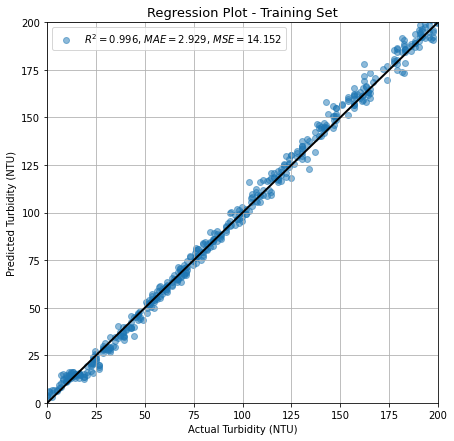

In [ ]:
fig, ax = plt.subplots(1,figsize=(7,7))

ax.scatter(train_true,train_pred, label=f'$R^2=${round(r2_train,3)}, $MAE=${round(MAE_train,3)}, $MSE=${round(MSE_train,3)}', color='tab:blue', alpha=0.5)
theta = np.polyfit(train_true, train_pred, 1)
y_line = theta[1] + theta[0] * train_true
ax.plot([train_true.min(), train_true.max()], [train_true.min(),train_true.max()], 'k-', lw=2)
ax.set_xlabel('Actual Turbidity (NTU)', fontsize=10)
ax.set_ylabel('Predicted Turbidity (NTU)', fontsize=10)
ax.set_title(f'Regression Plot - Training Set', fontsize=13)
ax.set_xlim([0, 200])
ax.set_ylim([0, 200])
ax.grid()
ax.legend()

plt.subplots_adjust(wspace=0.3)
plt.savefig(f'plots/{name}/RegressionPlotTrain_{name}.png', dpi=300)
plt.show()

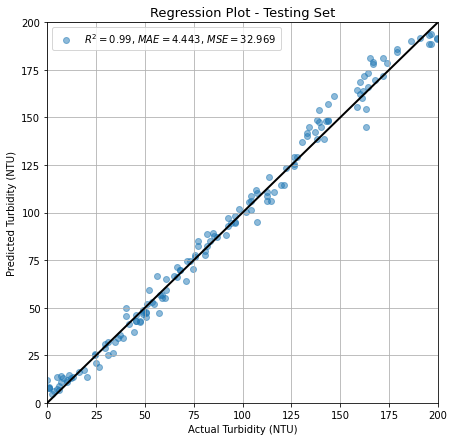

In [ ]:
fig, ax = plt.subplots(1,figsize=(7,7))

ax.scatter(test_true,test_pred, label = f'$R^2=${round(r2_test,3)}, $MAE=${round(MAE_test,3)}, $MSE=${round(MSE_test,3)}', color='tab:blue', alpha=0.5)
theta2 = np.polyfit(test_true, test_pred, 1)
y_line2 = theta2[1] + theta2[0] * test_true
ax.plot([test_true.min(), test_true.max()], [test_true.min(), test_true.max()], 'k-', lw=2)
ax.set_xlabel('Actual Turbidity (NTU)', fontsize=10)
ax.set_ylabel('Predicted Turbidity (NTU)', fontsize=10)
ax.set_title(f'Regression Plot - Testing Set', fontsize=13)
ax.set_xlim([0, 200])
ax.set_ylim([0, 200])
ax.grid()
ax.legend()

plt.subplots_adjust(wspace=0.3)
plt.savefig(f'plots/{name}/RegressionPlotTest_{name}.png', dpi=300)
plt.show()

In [ ]:
save_path = f"/content/gdrive/MyDrive/Hasil_Train/Training/Final"
if not os.path.exists(save_path):
  os.makedirs(save_path)

oripath = "plots/."
!cp -a "{oripath}" "{save_path}" # copies files to google drive
print("Done!")

Done!
